# Assignment 5B (Monte Carlo)
* @Shachidev 
` Date: 12-02-2025`

 * Details of the system
     - N = 216
     - rho = 0.8442
     - mass = 1.0
     - $\sigma$ = 1.0
     - $\epsilon$ = 1.0
     - r$_\text{cut}$ = 2.5$\sigma$
     - dt = 0.001
     - kBT = 1.0

In [10]:
# Full MD code

import time
import sys
import numpy as np
import matplotlib.pyplot as plt


### Parameters of the system

In [11]:
N=216     # Total no. of particles.(cube root must be integer)
m=1.0
sig=1.0
roh=0.8442
epsilon = 1.0
rc = 2.5    # cutoff lenth
box_length = 6.348475790538236 # for roh = 0.8442
mean, k_B = 0, 1.0
T  = 0.1  # Initial temprature(used for velociti init)
T0 = 1.0   # Desired temprature
beta = 1/(k_B * T0)

dr = 0.5*sig

# Functions

## Velocity initialize

In [12]:
import numpy as np
N = 216   # Number of particles
def velocity_initialize(N):
    """Initialize velocities of N particles from a normal distribution, 
    remove net momentum, and normalize."""
    
    std_dev = k_B * T
    bins = int(np.sqrt(N))

    # Generate velocities and remove net momentum
    velocities = np.random.normal(mean, std_dev, (N, 3))
    velocities -= velocities.mean(axis=0)

    # Normalize to match desired temperature
    temperature = 0.5 * np.sum(velocities**2)
    velocities *= np.sqrt(T/temperature)

    temperature = 0.5 * np.sum(velocities**2)
    print('Temperature = ', temperature)
    
    return velocities[:, 0], velocities[:, 1], velocities[:, 2]
    

## periodic boundary condition and minimum image convention

In [13]:
import math
def PBC(coord,box_length):
    """
    PBC is applied in this function.
    coord: 2D array of size (particle no. , 3)
    box_lenth: lenth of one side of cubic box
    """

    # 
    for i in range(N): 
        for j in range(3):
            if (coord[i, j] > box_length):
                coord[i, j] -= box_length* math.floor(coord[i, j]/box_length)
            elif (coord[i, j] < 0.0):
                coord[i, j] -= box_length* math.floor(coord[i, j]/box_length)
    return coord

def min_img_conv(coordinate1, coordinate2, box_length):
    displacement = coordinate2 - coordinate1
    displacement -= np.round(displacement / box_length) * box_length
    return displacement



## Energy calculation

In [14]:
def potenergy(coordinates):
    """
    Total potential energy of the sysrem is calculated.
    input: coordinates (posns of the particles).
    other variables(N,rc) inside the function are global variable.
    output: total potential energy.
    """
    rc2 = rc**2
    total_pot = 0.0
    r2c = 1/rc2
    r6c = r2c**3
    pot_cut = 4.0*r6c*(r6c-1)
  
    for i in range(N-1):
        for j in range(i+1,N):
            dx,dy,dz = min_img_conv(coordinates[j,:], coordinates[i,:], box_length)
            r2 = dx**2+dy**2+dz**2
            if (r2 < rc2) :
                r2i = 1/r2
                r6i = r2i**3
                total_pot = total_pot + 4.0*r6i*(r6i-1)- pot_cut
    return total_pot


# energy for one particle 
def energy(coordinates, p_coord, particle_no):
    """
    potential energy of one particle is calculated.
    input: coordinates, p_coord (posns of that particle) and particle_no.
    other variables(N,rc) inside the function are global variable.
    output: potential energy for that particle.
    """
    rc2 = rc**2
    total = 0.0
    r2c = 1/rc2
    r6c = r2c**3
  
    for j in range(1,N):
        if ( j != particle_no) : 
            dx,dy,dz = min_img_conv(coordinates[j,:], p_coord , box_length)
            r2 = dx**2+dy**2+dz**2
            if (r2 < rc2) :
                r2i = 1/r2
                r6i = r2i**3
                total = total + 4.0*r6i*(r6i-1)
    return total
            

## Monte carlo move

In [15]:
from numpy import random
def mcmove(coords):

    rand_p = random.randint(0, N - 1)
    ui = energy(coords, coords[rand_p,:],rand_p)
    randx = (np.random.random(3) - 0.5) * 2 * dr
    coord_new =coords[rand_p, :]+ randx
    uf = energy(coords, coord_new,rand_p)

    if (random.random() < np.exp(- beta*(uf - ui)) ):
        coords[rand_p, :] = coord_new
    return coords
    

## Sampling

In [16]:
def write_gro(file_pointer, coordinates, velocities, box_dims, residue_name, atom_name):
    r"""
    Appends a frame to a .gro file.

    Parameters:
    - file_pointer: Open file object in append mode.
    - coordinates: array of (x, y, z) tuples for atom positions in nm.
    - velocities:array of (vx, vy, vz) tuples for atom velocities in nm/ps.
    - box_dims: array of (x, y, z) for box dimensions in nm.
    - residue_name: Residue name (default: 'Ar').
    - atom_name: Atom name (default: 'Ar').
    """
    num_atoms = len(coordinates)

    # Write frame header and number of atoms
    file_pointer.write("Appended Frame\n")
    file_pointer.write(f"{num_atoms:5d}\n")

    # Write atom information
    for i, ((x, y, z), (vx, vy, vz)) in enumerate(zip(coordinates, velocities), start=1):
        residue_number = 1  # Default residue number
        atom_number = i
        file_pointer.write(f"{residue_number:5d}{residue_name:<5}{atom_name:>5}{atom_number:5d}{x:8.3f}{y:8.3f}{z:8.3f}{vx:8.4f}{vy:8.4f}{vz:8.4f}\n")

    # Write box dimensions
    file_pointer.write(f"{box_dims[0]:10.5f}{box_dims[1]:10.5f}{box_dims[2]:10.5f}\n")
    

# Main Program

In [17]:
cpu_start = time.process_time()

# position initiaalize
d = 1.0
box_dims=(box_length, box_length, box_length)
coordds = np.array([[i, j, k] for i in range(6) for j in range(6) for k in range(6)], dtype=float) * d
coordds += d / 2

x, y, z = coordds.T
print('Position initialized!!')

# call the function for velocity init
vx,vy,vz=velocity_initialize(N)
print('Velocity initialized!!')

# pack into 2d array
V=np.column_stack((vx, vy, vz))
X=np.column_stack((x, y, z))
# Initial configuration store
with open("init.gro", "w") as f:
        f.write(f"216 particles in a box intrect with L-J pot \n")
        f.write('216\n')
for i in range(N):
    with open("init.gro", "a") as f:
        f.write(f"1 \t Ar \t Ar \t {i:4d} \t {X[i,0]:.8f}\t{X[i,1]:.8f}\t{X[i,2]:.8f} \n")
with open("init.gro", "a") as f:
        f.write(f" {box_length:.8f}\t{box_length:.8f}\t{box_length:.8f} \n")



#Main loop of the simulation                  <-------------------------------------------
Etot = 0.0
Temp = 0.0
with open("energies_mc.txt", "w") as file:
    file.write(f" Time \t \t step \t \t Pot_energy \n")
    
# Parameters for ain loop                  <-------------------------------------------
t = 0.0
dt = 0.001

count=0
max_count = 1000
while (count < max_count):
    X = mcmove(X)
    Total_pot = potenergy(X)/N
    X = PBC(X,box_length)
 
    if (np.mod(count,10) == 0):
        with open("energies_mc.txt", "a") as file:
            file.write(f"{t:.8f} \t {count:6d} \t {Total_pot:.8e} \n")
        with open("mc.gro", "a") as f:
            write_gro(f, X, V, box_dims, "Ar", "Ar")
    t = t + dt
    count=count+1


print('DONE!!!  Value are stored in the file')
cpu_end = time.process_time()
print("CPU Time(s) = ", cpu_end - cpu_start)



Position initialized!!
Temperature =  0.1
Velocity initialized!!
DONE!!!  Value are stored in the file
CPU Time(s) =  547.765625


## Energy vs time Ploting 

Data shape: (100, 3)


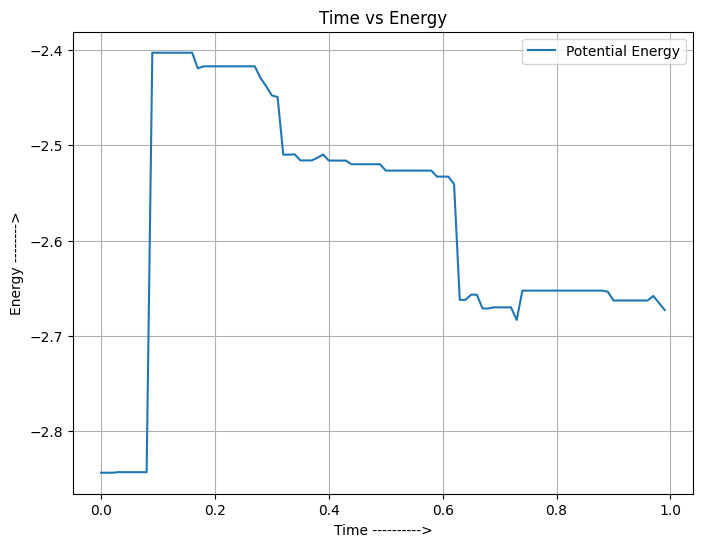

In [18]:
# Load data from file and ploting of energies
data = np.loadtxt("energies_mc.txt", skiprows=1,ndmin=2)
print("Data shape:", data.shape)
# Extract columns
time = data[:, 0]         
potential_energy = data[:, 2]  
   

# Plot the data
plt.figure(figsize=(8, 6))

plt.plot(time, potential_energy, label="Potential Energy", linestyle="-")

# Labels and Title
plt.xlabel("Time ---------->")
plt.ylabel("Energy -------->")
plt.title("Time vs Energy")
plt.legend()
plt.grid(True)

plt.savefig("mc.pdf", format="pdf", dpi=300, bbox_inches="tight")
# Show the plot
plt.show()
